In [6]:
import sys
import sklearn
import numpy as np
from sklearn.linear_model import SGDClassifier

# load mnist data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist.data, mnist.target

C:\Users\mager\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
# 1. convert target labels to True False for 3 and other digits
y_train_3 = (y[:60000] == '3')
y_test_3 = (y[60000:] == '3')

# 2. train SGD classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X[:60000], y_train_3)

# test prediction on first image
sgd_clf.predict([X[0]])

array([False])

In [3]:
# 3. Evaluate Classifier with cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X[:60000], y_train_3, cv=3, scoring='accuracy')

array([0.9496 , 0.9624 , 0.96275])

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# default threshold confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X[:60000], y_train_3, cv=3)
print('Confusion Matrix: Default Threshold')
print(confusion_matrix(y_train_3, y_train_pred))

# compute metrics
accuracy = accuracy_score(y_train_3, y_train_pred)
precision = precision_score(y_train_3, y_train_pred)
recall = recall_score(y_train_3, y_train_pred)
f1 = f1_score(y_train_3, y_train_pred)
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

Confusion Matrix: Default Threshold
[[53477   392]
 [ 2113  4018]]
Accuracy: 0.96, Precision: 0.91, Recall: 0.66, F1: 0.76


Confusion Matrix: Alt Threshold
[[53753   116]
 [ 3132  2999]]
Accuracy: 0.95, Precision: 0.96, Recall: 0.49, F1: 0.65


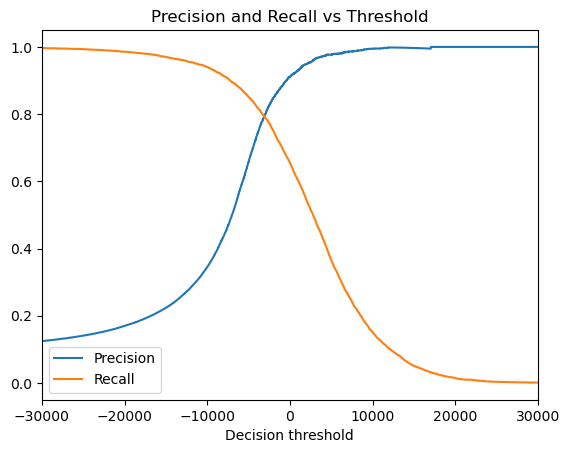

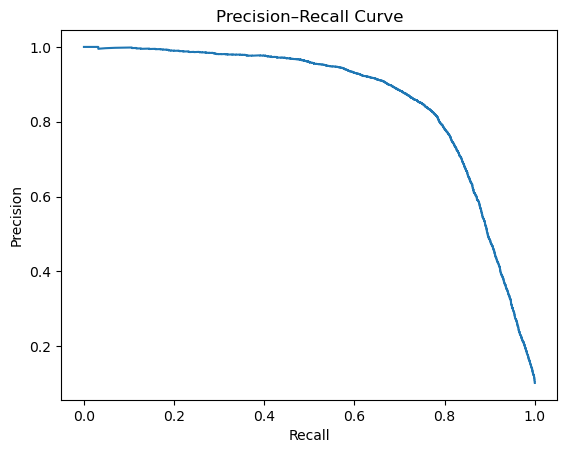

Best threshold (max F1=0.799): -2448.343
Confusion matrix at optimal threshold:
[[52892   977]
 [ 1399  4732]]
Accuracy: 0.96, Precision: 0.83, Recall: 0.77, F1: 0.80


In [7]:
# Alternate threshold confusion matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_train_pred_alt = cross_val_predict(sgd_clf, X[:60000], y_train_3, cv=3, method="decision_function")
threshold = 3000
y_pred_thresh = (y_train_pred_alt >= threshold)
print('Confusion Matrix: Alt Threshold')
print(confusion_matrix(y_train_3, y_pred_thresh))

# compute metrics
accuracy = accuracy_score(y_train_3, y_pred_thresh)
precision = precision_score(y_train_3, y_pred_thresh)
recall = recall_score(y_train_3, y_pred_thresh)
f1 = f1_score(y_train_3, y_pred_thresh)
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

# 2) Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_train_pred_alt)

# 3a) Plot precision & recall vs. threshold
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1],    label="Recall")
plt.xlim(-30000,30000)
plt.xlabel("Decision threshold")
plt.legend(loc="best")
plt.title("Precision and Recall vs Threshold")
plt.show()

# 3b) (optional) Plot Precision vs Recall curve
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# 4) Find threshold that maximizes F1
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_idx       = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold (max F1={f1_scores[best_idx]:.3f}): {best_threshold:.3f}")

# 5) Use that threshold for new predictions
y_pred_optimal = (y_train_pred_alt >= best_threshold)
print("Confusion matrix at optimal threshold:")
print(confusion_matrix(y_train_3, y_pred_optimal))

# compute metrics
accuracy = accuracy_score(y_train_3, y_pred_optimal)
precision = precision_score(y_train_3, y_pred_optimal)
recall = recall_score(y_train_3, y_pred_optimal)
f1 = f1_score(y_train_3, y_pred_optimal)
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')

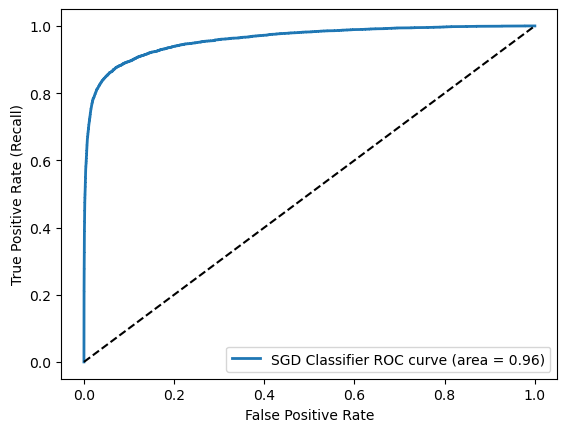

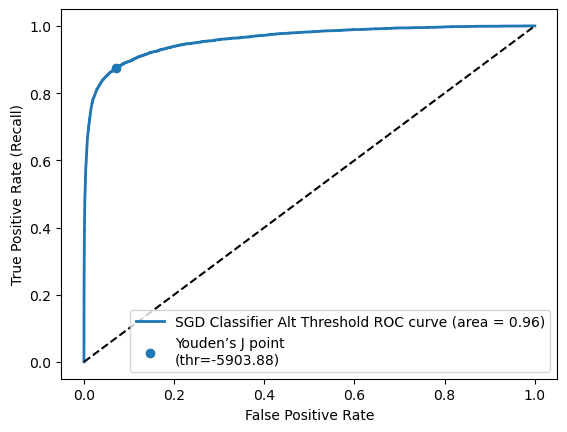

In [8]:
from sklearn.metrics import roc_curve, auc

# for roc curve
y_scores = cross_val_predict(sgd_clf, X[:60000], y_train_3, cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
roc_auc = auc(fpr, tpr)

# plot
plt.plot(fpr, tpr, linewidth=2, label=f'SGD Classifier ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

# for opt threshold roc curve
fpr, tpr, thresholds = roc_curve(y_train_3, y_train_pred_alt)
roc_auc = auc(fpr, tpr)
J  = tpr - fpr
ix = np.argmax(J)
optimal_threshold = thresholds[ix]

# plot
plt.plot(fpr, tpr, linewidth=2, label=f'SGD Classifier Alt Threshold ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.scatter(fpr[ix], tpr[ix],
            label=f"Youden’s J point\n(thr={optimal_threshold:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

In [9]:
from collections import Counter

fp_mask_default = (y_train_pred == True) & (y_train_3 == False)
fp_mask_f1 = (y_pred_optimal == True) & (y_train_3 == False)

# now count the actual digits for each case:
digits = y[:60000]  # the true labels as strings

print("Default threshold false-positive breakdown:")
for digit, cnt in Counter(digits[fp_mask_default]).items():
    print(f"  predicted 3 but was {digit}: {cnt}")
print("Total FP (default):", fp_mask_default.sum())

print("\nF1-optimal threshold false-positive breakdown:")
for digit, cnt in Counter(digits[fp_mask_f1]).items():
    print(f"  predicted 3 but was {digit}: {cnt}")
print("Total FP (F1 opt):", fp_mask_f1.sum())


Default threshold false-positive breakdown:
  predicted 3 but was 5: 171
  predicted 3 but was 8: 58
  predicted 3 but was 7: 26
  predicted 3 but was 2: 58
  predicted 3 but was 1: 28
  predicted 3 but was 0: 11
  predicted 3 but was 4: 17
  predicted 3 but was 9: 22
  predicted 3 but was 6: 1
Total FP (default): 392

F1-optimal threshold false-positive breakdown:
  predicted 3 but was 4: 44
  predicted 3 but was 5: 317
  predicted 3 but was 2: 168
  predicted 3 but was 7: 97
  predicted 3 but was 8: 120
  predicted 3 but was 9: 64
  predicted 3 but was 1: 132
  predicted 3 but was 0: 32
  predicted 3 but was 6: 3
Total FP (F1 opt): 977


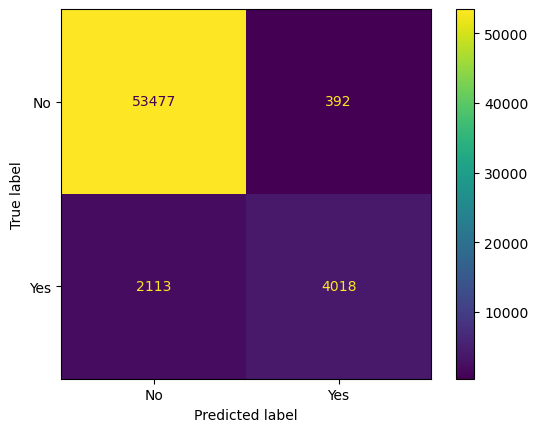

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_train_3, y_train_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
disp.plot()
plt.show()